<a href="https://colab.research.google.com/github/AvantiShri/BioMate/blob/master/%20looking%20at%20top%203%20peaks%20instead%20of%20just%20top%20peak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])/windowsize
  return smooth_arr

def get_smoothed_arrs(arrs, windowsize):
  arr_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  smooth_arr = (arr_cumsum[:,windowsize:] - arr_cumsum[:,:-windowsize])/windowsize
  return smooth_arr

def totaltopn_smoothedarr(smoothedarr, windowsize, n): #total from the top n
  smoothedarr = smoothedarr.copy()
  topn_total = 0
  for _ in range(n):
    maxidx = np.argmax(smoothedarr)
    topn_total += smoothedarr[maxidx]
    smoothedarr[maxidx-int(windowsize/2.0) : maxidx+(windowsize-int(windowsize/2.0))] = -np.inf
  return topn_total

def totaltopn_smoothedarrs(smoothedarrs, windowsize, n): #total from the top n
  smoothedarrs = smoothedarrs.copy()
  topn_totals = np.zeros(smoothedarrs.shape[0])
  flankbefore = int(windowsize/2.0)
  flankafter = windowsize-flankbefore
  for _ in range(n):
    maxidxs = np.argmax(smoothedarrs, axis=-1)
    for i,maxidx in enumerate(maxidxs):
      topn_totals[i] += smoothedarrs[i,maxidx]
      smoothedarrs[i,maxidx-flankbefore:maxidx+flankafter] = -np.inf
  return topn_totals

def ljungbox_lag1(values):
  values = values - np.mean(values) #demean
  var = np.sum(values*values)/len(values)
  acf = np.sum(values[1:]*values[:-1])/(len(values)*var)
  sacf2 = acf**2/(len(values) - 1)
  qljungbox = len(values)*(len(values)+2)*sacf2

  return qljungbox, scipy.stats.chi2.sf(qljungbox, 1)

def ljungboxq_lag1_manyvals(values_2darr):
  values_2darr = values_2darr - np.mean(values_2darr, axis=1)[:,None]
  vars = np.sum(values_2darr*values_2darr, axis=1)/values_2darr.shape[1]
  acfs = np.sum(values_2darr[:,1:]*values_2darr[:,:-1], axis=1)/(values_2darr.shape[1]*vars)
  sacfs2 = np.square(acfs)/(values_2darr.shape[1] - 1)
  qsljungbox = values_2darr.shape[1]*(values_2darr.shape[1]+2)*sacfs2

  return qsljungbox

def perform_powerspectrum_analysis(values, num_permutations):

  toreturndict = {}

  ljungbox_q, ljungbox_p = ljungbox_lag1(values)
  toreturndict['pval_ljundbox'] = ljungbox_p

  freqs = np.fft.rfftfreq(len(values), 1)
  rps = get_relative_power_spectrum(values)

  #permute the test data sequence num_permutations times to get an empirical null
  rng = np.random.RandomState(1234)
  rps_permute_2darr = np.array([get_relative_power_spectrum(rng.permutation(values))
                                  for i in range(num_permutations)])

  uniform_expectation = 1.0/len(rps)

  expected_freq = np.sum(freqs*rps)
  expected_freq_permute_arr = np.sum(freqs[None,:]*rps_permute_2darr, axis=1)
  pval_ef = np.mean(expected_freq_permute_arr >= expected_freq)

  maxd = np.max(np.abs(np.cumsum(rps - uniform_expectation)))
  maxd_permute_arr = np.max(np.abs(np.cumsum(rps_permute_2darr - uniform_expectation, axis=1)), axis=1);
  pval_maxd = np.mean(maxd_permute_arr >= maxd)

  smooth_pvals = {}
  sumtopnsmooth_pvals = {}
  peak_freqs = {} #just for information purposes
  freq_stepsize = freqs[1]
  smoothfreqwindows = [('p00625', 0.00625),
                       ('p0075', 0.0075),
                       ('p01', 0.01),
                       ('p0125', 0.0125),
                       ('p015', 0.015),
                       ('p02', 0.02),
                       ('p025', 0.025),
                       ('p05', 0.05)]
  for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
    windowsize = int(smoothfreqwindow/freq_stepsize)
    smooth_rps = get_smoothed_arr(rps, windowsize)
    smooth_xaxis = get_smoothed_arr(freqs, windowsize)
    argmax_smooth_rps = np.argmax(smooth_rps)
    max_smooth_rps = smooth_rps[argmax_smooth_rps]
    peak_freq = smooth_xaxis[argmax_smooth_rps]

    smooth_rps_permutetest_2darr = get_smoothed_arrs(rps_permute_2darr, windowsize)
    max_smooth_rps_permutetest_2darr = np.max(smooth_rps_permutetest_2darr, axis=1)
    pval_smooth = np.mean(max_smooth_rps_permutetest_2darr
                   >= max_smooth_rps)

    n=3
    sumtopn_smooth_rps = totaltopn_smoothedarr(smooth_rps, windowsize, n)
    sumtopn_smooth_rps_permutetest_2darr = totaltopn_smoothedarrs(smooth_rps_permutetest_2darr, windowsize, n)
    pval_sumtopnsmooth = np.mean(sumtopn_smooth_rps_permutetest_2darr
                                 >= sumtopn_smooth_rps)

    smooth_pvals[smoothfreqwindow] = pval_smooth
    sumtopnsmooth_pvals[smoothfreqwindow] = pval_sumtopnsmooth
    peak_freqs[smoothfreqwindow] = peak_freq

  toreturndict['pval_ef'] = pval_ef,
  toreturndict['pval_maxd'] = pval_maxd
  for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
    toreturndict['pval_smooth_'+smoothfreqname] = smooth_pvals[smoothfreqwindow]
    toreturndict['pval_sumtopnsmooth_'+smoothfreqname] = sumtopnsmooth_pvals[smoothfreqwindow]
  toreturndict['peak_freqs'] = peak_freqs

  return (toreturndict, (freqs, rps))


In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [5]:
event_metadata_list

[['Event391', 'Internat Day Peace', 0.0008192443394802185],
 ['Event289', 'Meditations Valentines Day', 0.002569859448349643],
 ['Event487', 'September 21', 0.003153268038066148],
 ['Event217', 'Indonesian Earthquake', 0.0032705236405630167],
 ['Event203', 'Baghdad Bridge Stampede', 0.007938503795130725],
 ['Event472', 'Mandela Dies', 0.008229306940944703],
 ['Event360', 'Brazilian Mudslides', 0.012434298335079697],
 ['Event266', 'Obama Wins Nomination', 0.014699315651582556],
 ['Event395', 'Steve Jobs Dies', 0.015513261511045151],
 ['Event341', 'Chilean Miners Alive', 0.0159787032720784],
 ['Event199', 'Oraworld Resonance', 0.016077254762331683],
 ['Event437', 'Dr. Tomorrow Passes', 0.01899878662499621],
 ['Event413', 'Mogadishu Bombing', 0.01933102456739566],
 ['Event56', 'Pierre Trudeau Funeral', 0.021572192676071245],
 ['Event205', 'Bali Bombing 2', 0.022006592782255807],
 ['Event324', 'Health Care is Law', 0.02369816101463118],
 ['Event272', 'Palin Acceptance 080903', 0.0239297717

In [6]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

csm1_zscores = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

pvals_csm1 = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

event_count = 0

dont_rerun_if_file_exists = True
savefolder = "/content/drive/MyDrive/GCP_data/analysis/indivevents_morecontrols"
!mkdir $savefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3', 'control4']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    #for each of the scores, we will sum across the
    # duration. Since the events are at least an hour long, this will
    # be a sum of at least 3600 random variables with mean 0 and variance
    # 2 (for csm1)
    # that are iid under the null hypothesis. By the central limit theorem,
    # their sum should be Gaussian with mean 0 and variance = len(timeseries)
    # Dividing by sqrt(len(timeseries)) yields a Z score.
    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1))
    print(spanname,"csm1 z score   :", csm1_zscore)
    csm1_zscores[spanname].append(csm1_zscore)

    for signaltype,signal,signalsavedict in [("csm1", csm1, pvals_csm1)]:
      outfile = savefolder+"/nperm"+str(NUM_PERMUTATIONS)+"_"+event+"_"+spanname+"_"+signaltype+"_analysissummary.json"
      if (dont_rerun_if_file_exists and os.path.isfile(outfile)):
        pvals = json.load(open(outfile))
      else:
        pvals, _ = perform_powerspectrum_analysis(signal, NUM_PERMUTATIONS)
        open(outfile, 'w').write(json.dumps(pvals, indent=4))
      print(signaltype, pvals)
      signalsavedict[spanname].append(pvals)


/content/drive/MyDrive/GCP_data
mkdir: cannot create directory ‘/content/drive/MyDrive/GCP_data/analysis/indivevents_morecontrols’: File exists

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test csm1 z score   : 3.148966694327055
csm1 {'pval_ljundbox': 0.6419708469641867, 'pval_ef': [0.641], 'pval_maxd': 0.793, 'pval_smooth_p00625': 0.208, 'pval_sumtopnsmooth_p00625': 0.234, 'pval_smooth_p0075': 0.225, 'pval_sumtopnsmooth_p0075': 0.1, 'pval_smooth_p01': 0.198, 'pval_sumtopnsmooth_p01': 0.126, 'pval_smooth_p0125': 0.266, 'pval_sumtopnsmooth_p0125': 0.097, 'pval_smooth_p015': 0.274, 'pval_sumtopnsmooth_p015': 0.089, 'pval_smooth_p02': 0.27, 'pval_sumtopnsmooth_p02': 0.231, 'pval_smooth_p025': 0.051, 'pval_sumtopnsmooth_p025': 0.046, 'pval_smooth_p05': 0.307, 'pval_sumtopnsmooth_p05': 0.213, 'peak_freqs': {'0.00625': 0.2422048611111121, '0.0075': 0.242135416666668, '0.01': 0.24120949074073939, '0.0125': 0.4895659722222212, '0

KeyboardInterrupt: ignored

In [7]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

#save the pvals
open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json", 'w').write(
     json.dumps(csm1_zscores, indent=4))
open(prefix+"_csm1.json","w").write(json.dumps(pvals_csm1, indent=4))

1383653

In [8]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [9]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

csm1_zscores = json.load(open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json"))

#load the pvals in case we want to remake the plots without rerunning the prev stuff
#prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

pvals_csm1 = json.load(open(prefix+"_csm1.json"))

In [10]:
def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([-np.log10(
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(pvals_csm1["test"])),
                  1.0/NUM_PERMUTATIONS)
      ) )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [11]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(pvals_csm1["test"])-1 #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals, savefilename):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals]]

  test_metapvals = get_iterative_metapvals(test_pvals)
  control1_metapvals = get_iterative_metapvals(control1_pvals)
  control2_metapvals = get_iterative_metapvals(control2_pvals)
  control3_metapvals = get_iterative_metapvals(control3_pvals)
  control4_metapvals = get_iterative_metapvals(control4_pvals)

  theslice = slice(min_meta-1, max_meta)

  handles = []

  rng = np.random.RandomState(1234)

  maxsimmetapval_arr = np.max(simulated_metapvals_arr[:,theslice], axis=1)
  maxtestmetapval = np.max(-np.log10(test_metapvals[theslice]))
  maxcontrol1metapval = np.max(-np.log10(control1_metapvals[theslice]))
  maxcontrol2metapval = np.max(-np.log10(control2_metapvals[theslice]))
  maxcontrol3metapval = np.max(-np.log10(control3_metapvals[theslice]))
  maxcontrol4metapval = np.max(-np.log10(control4_metapvals[theslice]))

  print("Testing for positive meta-analysis z-scores:")
  print("test pval:", np.sum(maxtestmetapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control3 pval:", np.sum(maxcontrol3metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control4 pval:", np.sum(maxcontrol4metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))

  print("Testing for negative meta-analysis z-scores:")
  print("test pval:", np.sum(maxtestmetapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control3 pval:", np.sum(maxcontrol3metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control4 pval:", np.sum(maxcontrol4metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))

  matplotlib.use('agg')
  fig = plt.figure(figsize=(15,4))
  #for simulated_metapvals in simulated_metapvals_arr:
  #  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-np.power(10,-simulated_metapvals[theslice])), color="orange", alpha=0.003)

  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-test_pvals[:max_meta]), color="blue", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control1_pvals[:max_meta]), color="green", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control2_pvals[:max_meta]), color="red", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control3_pvals[:max_meta]), color="purple", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control4_pvals[:max_meta]), color="pink", s=2)

  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-test_metapvals[theslice]), color="blue")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control1_metapvals[theslice]), color="green")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control2_metapvals[theslice]), color="red")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control3_metapvals[theslice]), color="purple")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control4_metapvals[theslice]), color="pink")

  plt.plot([min(xaxis_full), max(xaxis_full)],
           [0, 0],
           color="black", linestyle="--")
  plt.plot(xaxis_full, csm1_zscores["test"][:max_meta], color="black")
  plt.ylim(-4,4)
  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("Z-score") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                      mpatches.Patch(color='green', label='Control 1 signals (before)'),
                      mpatches.Patch(color='red', label='Control 2 signals (after)'),
                      #mpatches.Patch(color='orange', label='Null distribution ('+str(metatrends_to_sim)+' simulated)'),
                      mpatches.Patch(color='black', label='Original event Z-scores')
                    ],
             loc="lower left")
  fig.savefig("analysis/metapval_"+savefilename+'.png')
  plt.close(fig)
  plt.clf()

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
csm1 ljundbox
Testing for positive meta-analysis z-scores:
test pval: 0.1378
control1 pval: 0.3894
control2 pval: 0.2036
control3 pval: 0.24
control4 pval: 0.2934
Testing for negative meta-analysis z-scores:
test pval: 0.8622
control1 pval: 0.6106
control2 pval: 0.7964
control3 pval: 0.76
control4 pval: 0.7066


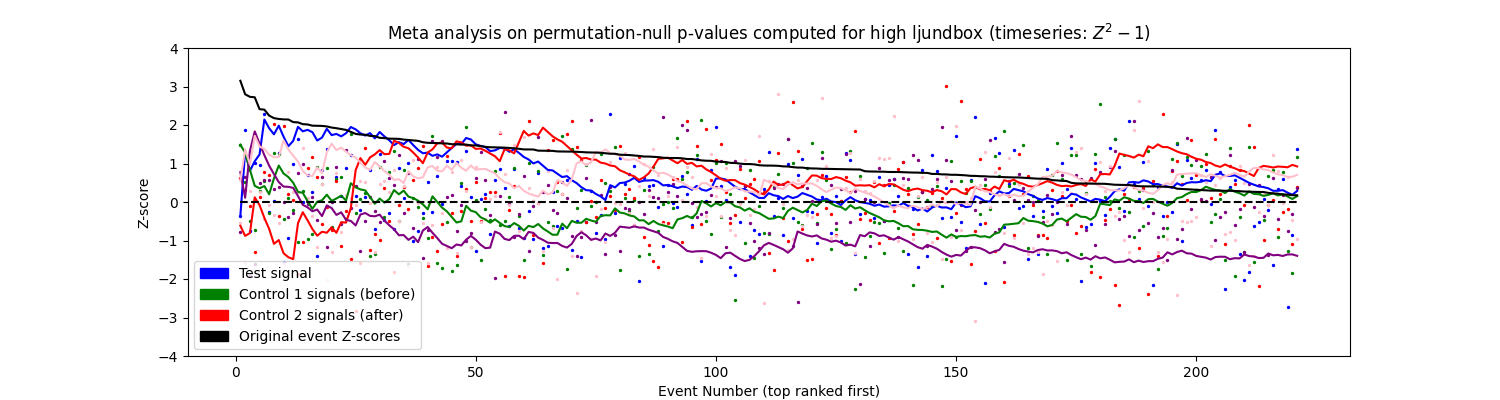

csm1 ef
Testing for positive meta-analysis z-scores:
test pval: 0.064
control1 pval: 0.7162
control2 pval: 0.1732
control3 pval: 0.5976
control4 pval: 0.4188
Testing for negative meta-analysis z-scores:
test pval: 0.936
control1 pval: 0.2838
control2 pval: 0.8268
control3 pval: 0.4024
control4 pval: 0.5812


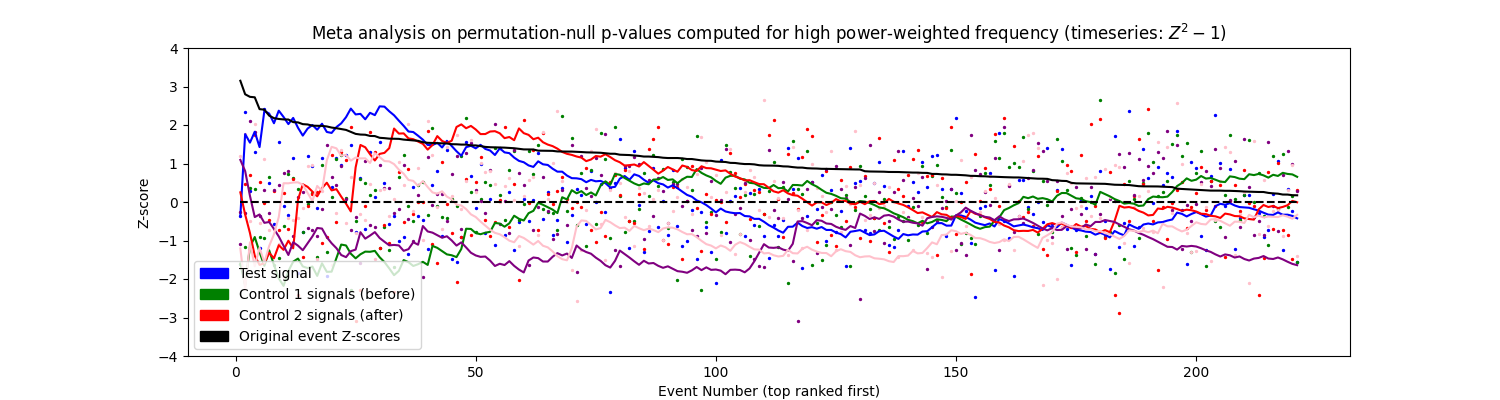

csm1 maxd
Testing for positive meta-analysis z-scores:
test pval: 0.1964
control1 pval: 0.451
control2 pval: 0.169
control3 pval: 0.39
control4 pval: 0.3714
Testing for negative meta-analysis z-scores:
test pval: 0.8036
control1 pval: 0.549
control2 pval: 0.831
control3 pval: 0.61
control4 pval: 0.6286


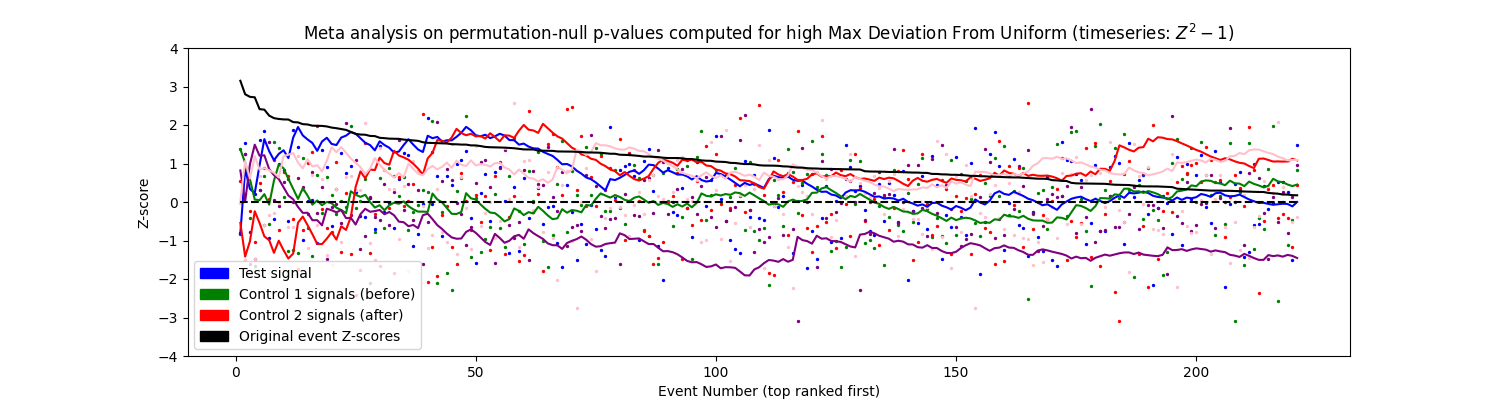

csm1 sumtopnsmooth_p00625
Testing for positive meta-analysis z-scores:
test pval: 0.3078
control1 pval: 0.9674
control2 pval: 0.3214
control3 pval: 0.068
control4 pval: 0.9482
Testing for negative meta-analysis z-scores:
test pval: 0.6922
control1 pval: 0.0326
control2 pval: 0.6786
control3 pval: 0.932
control4 pval: 0.0518


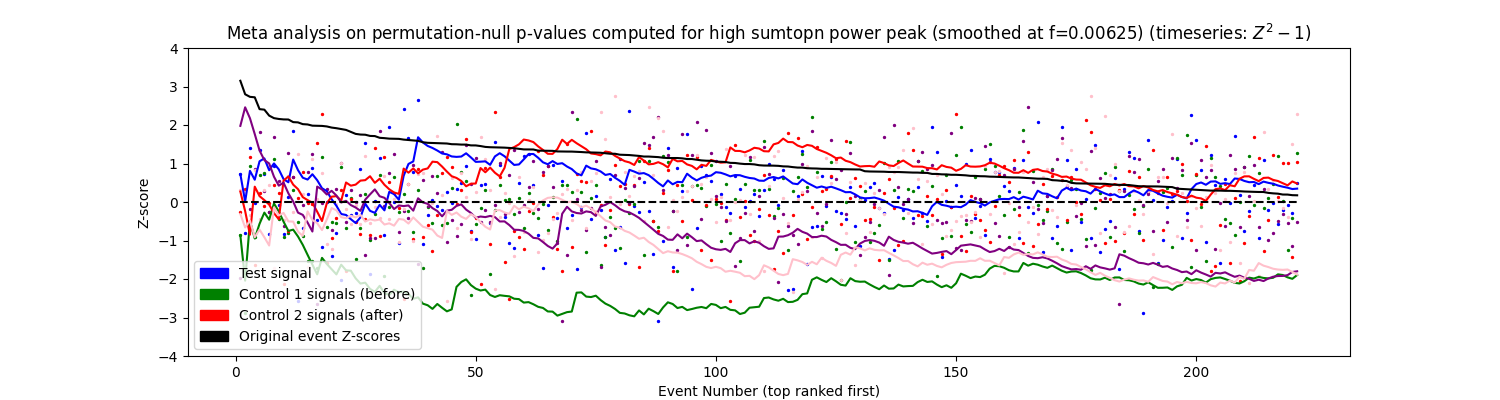

csm1 smooth_p00625
Testing for positive meta-analysis z-scores:
test pval: 0.2092
control1 pval: 0.9988
control2 pval: 0.5742
control3 pval: 0.1538
control4 pval: 0.821
Testing for negative meta-analysis z-scores:
test pval: 0.7908
control1 pval: 0.0012
control2 pval: 0.4258
control3 pval: 0.8462
control4 pval: 0.179


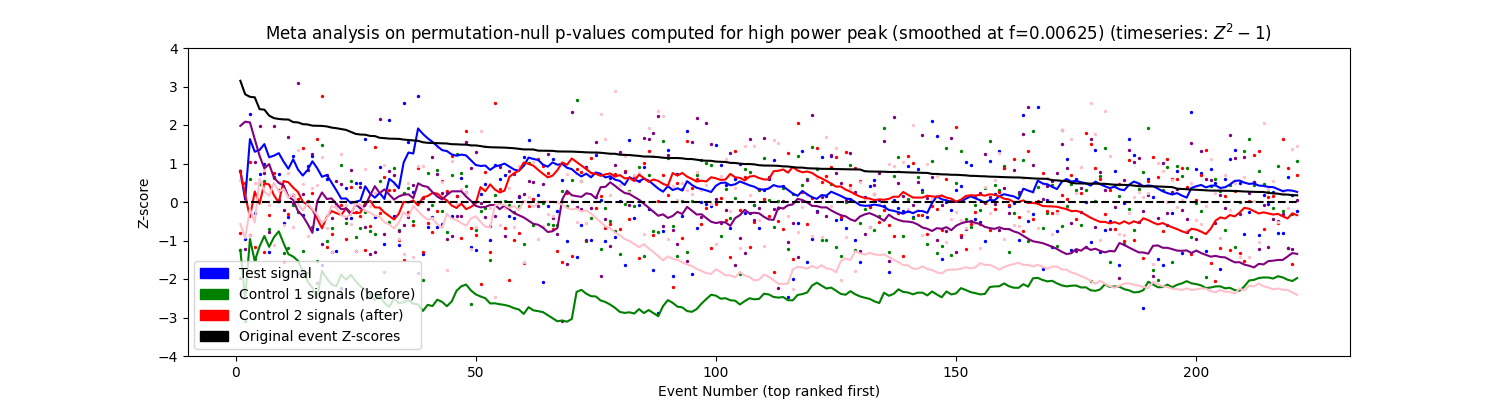

csm1 sumtopnsmooth_p0075
Testing for positive meta-analysis z-scores:
test pval: 0.1254
control1 pval: 0.9986
control2 pval: 0.3606
control3 pval: 0.3022
control4 pval: 0.9326
Testing for negative meta-analysis z-scores:
test pval: 0.8746
control1 pval: 0.0014
control2 pval: 0.6394
control3 pval: 0.6978
control4 pval: 0.0674


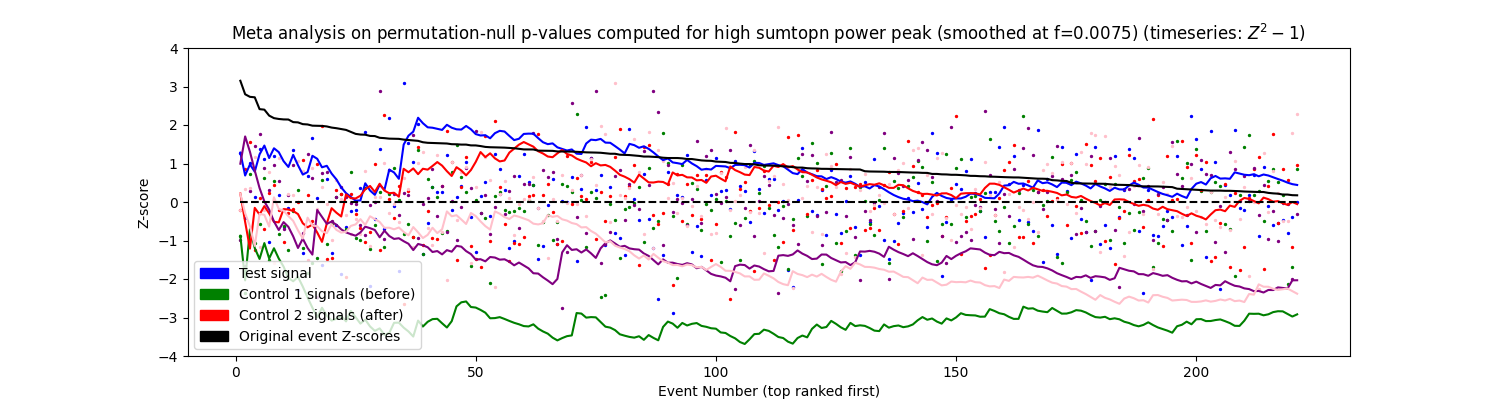

csm1 smooth_p0075
Testing for positive meta-analysis z-scores:
test pval: 0.1434
control1 pval: 0.9976
control2 pval: 0.477
control3 pval: 0.4148
control4 pval: 0.8744
Testing for negative meta-analysis z-scores:
test pval: 0.8566
control1 pval: 0.0024
control2 pval: 0.523
control3 pval: 0.5852
control4 pval: 0.1256


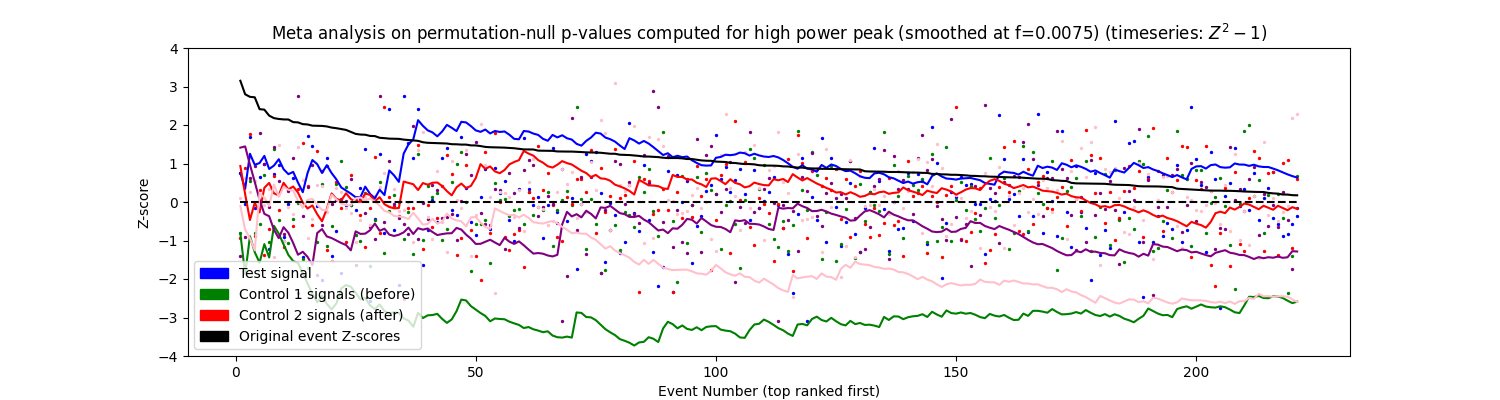

csm1 sumtopnsmooth_p01
Testing for positive meta-analysis z-scores:
test pval: 0.1826
control1 pval: 0.986
control2 pval: 0.5928
control3 pval: 0.1918
control4 pval: 0.6004
Testing for negative meta-analysis z-scores:
test pval: 0.8174
control1 pval: 0.014
control2 pval: 0.4072
control3 pval: 0.8082
control4 pval: 0.3996


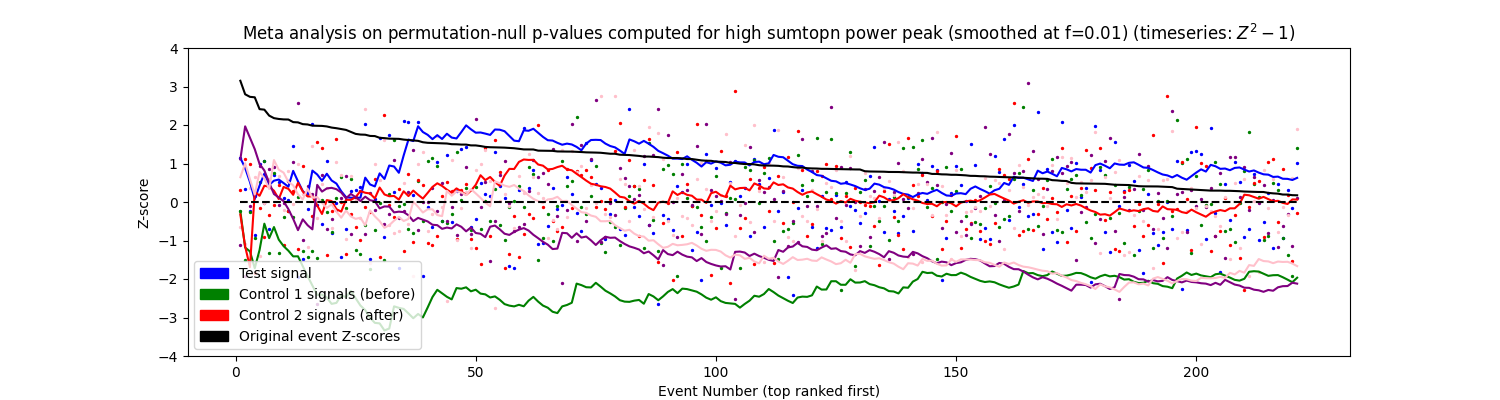

csm1 smooth_p01
Testing for positive meta-analysis z-scores:
test pval: 0.031
control1 pval: 0.9092
control2 pval: 0.6628
control3 pval: 0.3378
control4 pval: 0.69
Testing for negative meta-analysis z-scores:
test pval: 0.969
control1 pval: 0.0908
control2 pval: 0.3372
control3 pval: 0.6622
control4 pval: 0.31


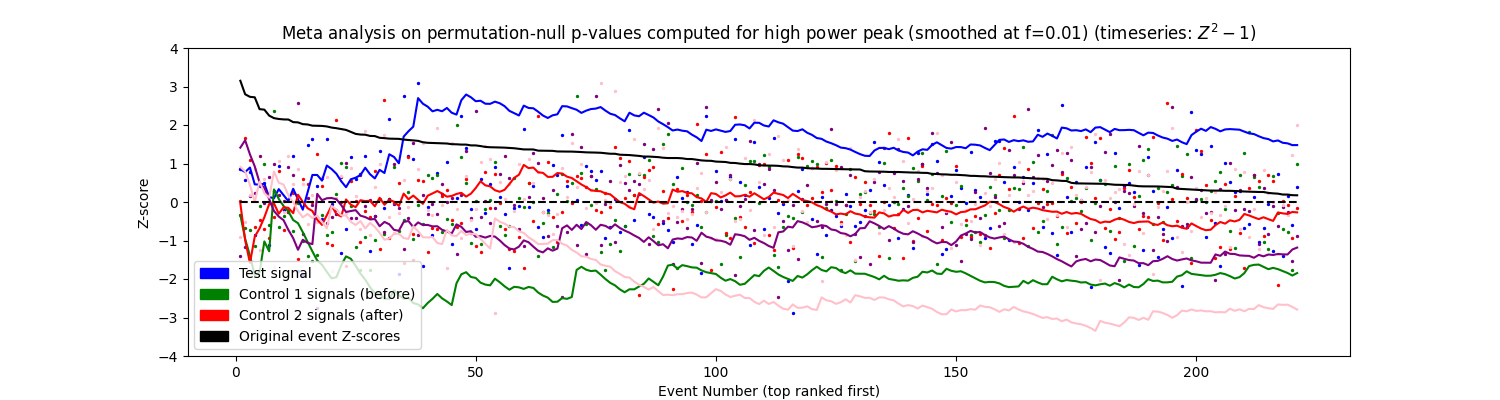

csm1 sumtopnsmooth_p0125
Testing for positive meta-analysis z-scores:
test pval: 0.0848
control1 pval: 0.9914
control2 pval: 0.734
control3 pval: 0.079
control4 pval: 0.6494
Testing for negative meta-analysis z-scores:
test pval: 0.9152
control1 pval: 0.0086
control2 pval: 0.266
control3 pval: 0.921
control4 pval: 0.3506


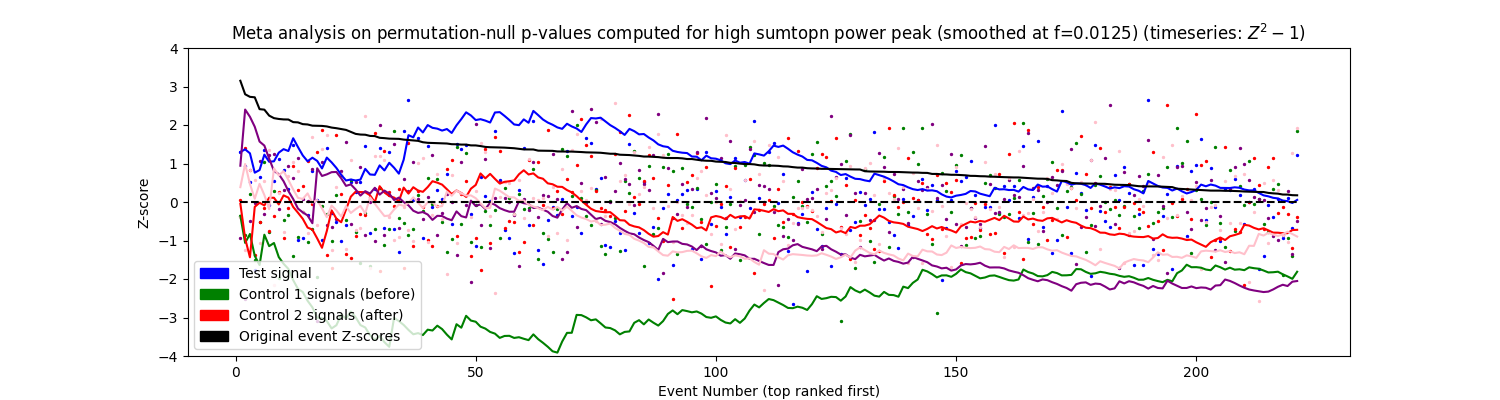

csm1 smooth_p0125
Testing for positive meta-analysis z-scores:
test pval: 0.0024
control1 pval: 0.945
control2 pval: 0.4996
control3 pval: 0.4314
control4 pval: 0.6118
Testing for negative meta-analysis z-scores:
test pval: 0.9976
control1 pval: 0.055
control2 pval: 0.5004
control3 pval: 0.5686
control4 pval: 0.3882


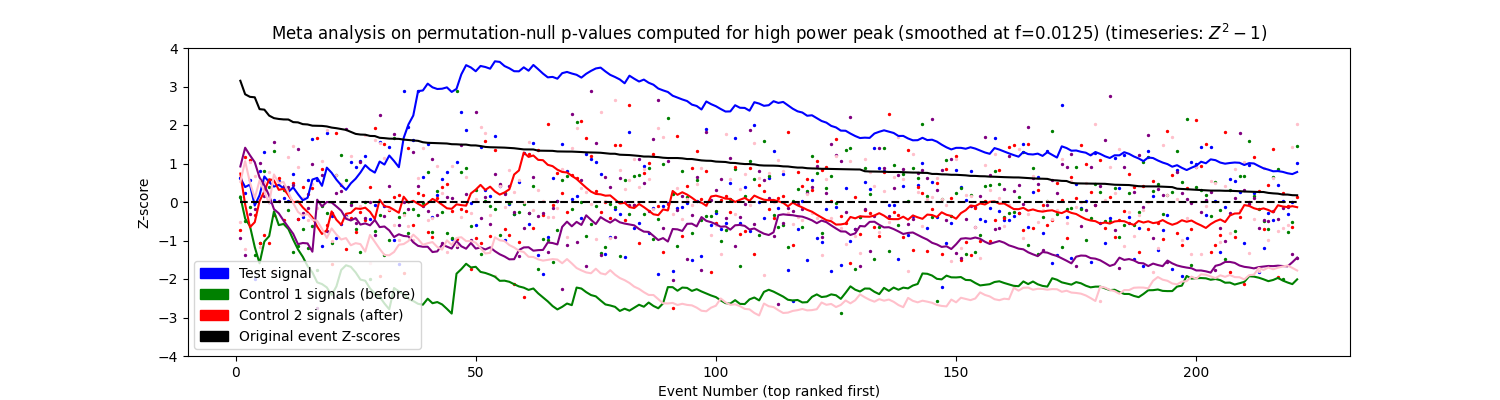

csm1 sumtopnsmooth_p015
Testing for positive meta-analysis z-scores:
test pval: 0.2488
control1 pval: 0.9898
control2 pval: 0.7642
control3 pval: 0.3712
control4 pval: 0.4426
Testing for negative meta-analysis z-scores:
test pval: 0.7512
control1 pval: 0.0102
control2 pval: 0.2358
control3 pval: 0.6288
control4 pval: 0.5574


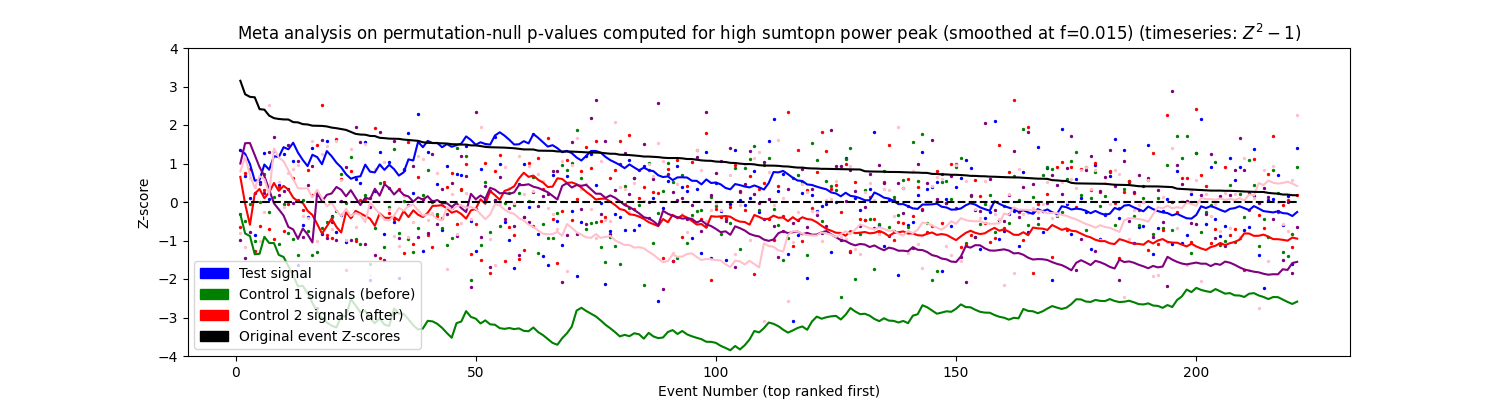

csm1 smooth_p015
Testing for positive meta-analysis z-scores:
test pval: 0.114
control1 pval: 0.9902
control2 pval: 0.3106
control3 pval: 0.5202
control4 pval: 0.39
Testing for negative meta-analysis z-scores:
test pval: 0.886
control1 pval: 0.0098
control2 pval: 0.6894
control3 pval: 0.4798
control4 pval: 0.61


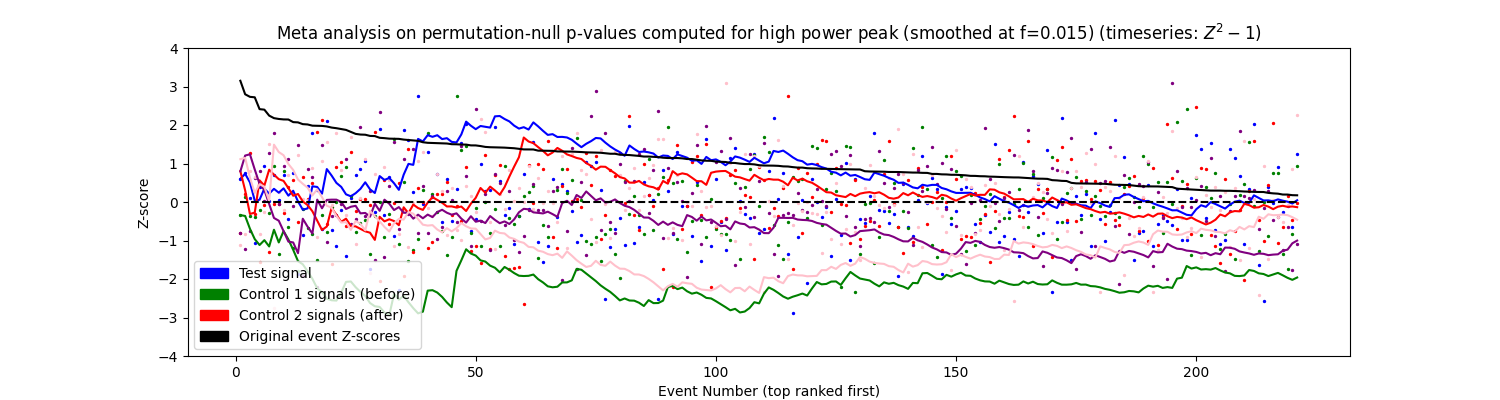

csm1 sumtopnsmooth_p02
Testing for positive meta-analysis z-scores:
test pval: 0.2658
control1 pval: 0.9976
control2 pval: 0.5594
control3 pval: 0.2558
control4 pval: 0.4108
Testing for negative meta-analysis z-scores:
test pval: 0.7342
control1 pval: 0.0024
control2 pval: 0.4406
control3 pval: 0.7442
control4 pval: 0.5892


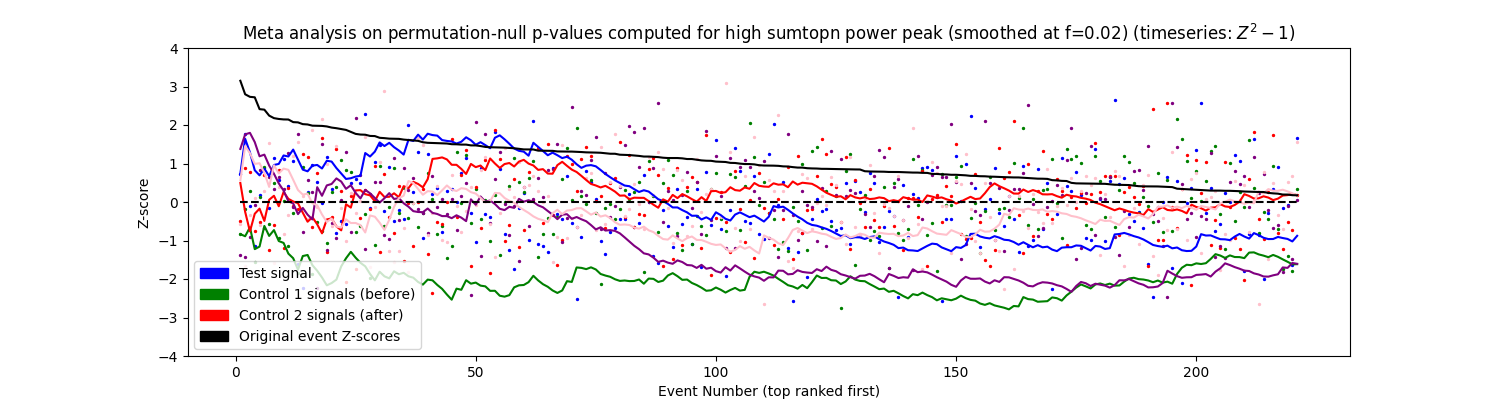

csm1 smooth_p02
Testing for positive meta-analysis z-scores:
test pval: 0.0426
control1 pval: 0.9624
control2 pval: 0.2862
control3 pval: 0.6298
control4 pval: 0.068
Testing for negative meta-analysis z-scores:
test pval: 0.9574
control1 pval: 0.0376
control2 pval: 0.7138
control3 pval: 0.3702
control4 pval: 0.932


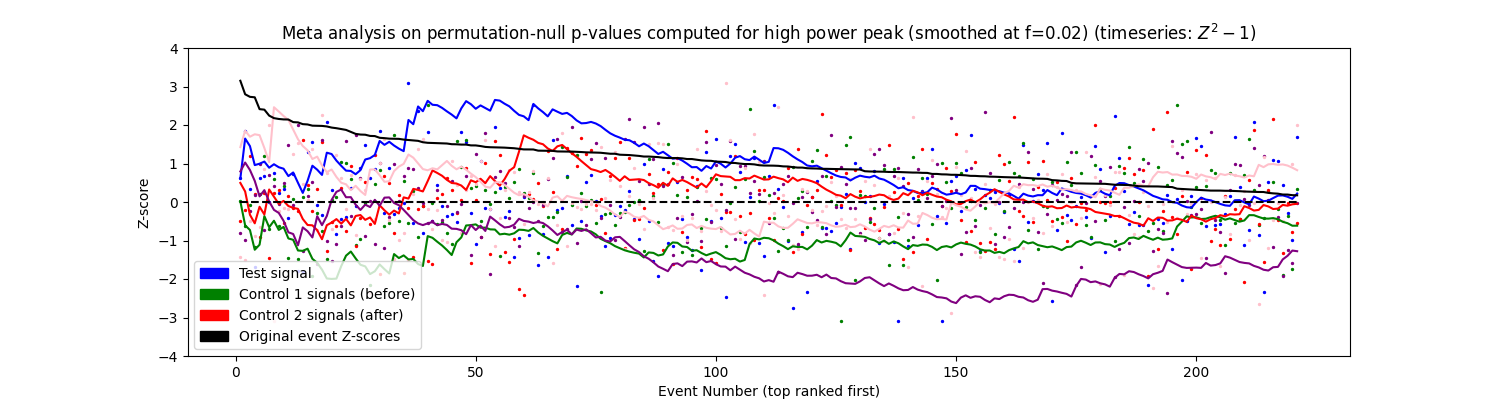

csm1 sumtopnsmooth_p025
Testing for positive meta-analysis z-scores:
test pval: 0.0044
control1 pval: 0.7766
control2 pval: 0.322
control3 pval: 0.6774
control4 pval: 0.7746
Testing for negative meta-analysis z-scores:
test pval: 0.9956
control1 pval: 0.2234
control2 pval: 0.678
control3 pval: 0.3226
control4 pval: 0.2254


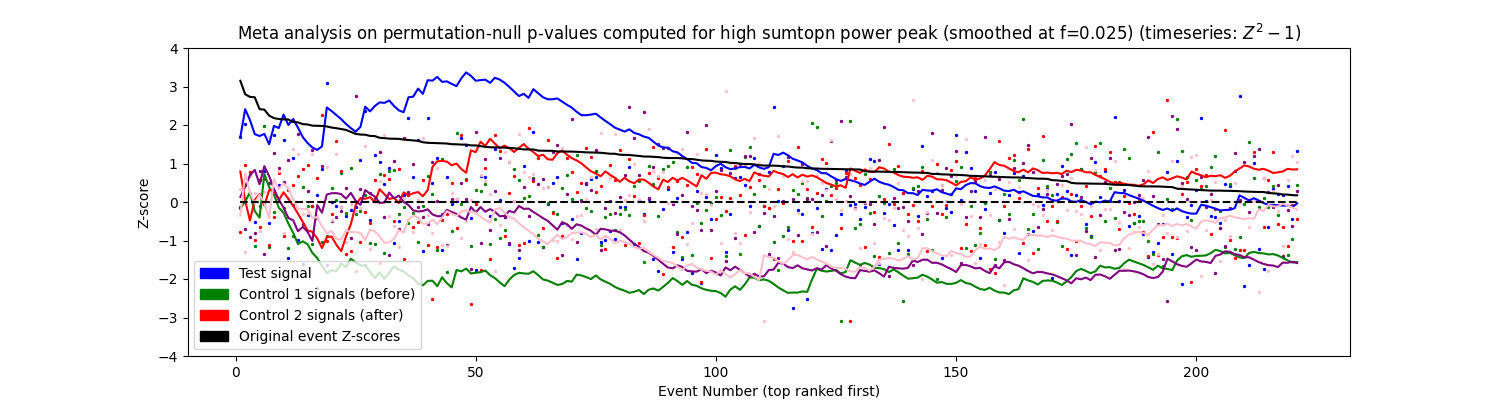

csm1 smooth_p025
Testing for positive meta-analysis z-scores:
test pval: 0.027
control1 pval: 0.7952
control2 pval: 0.3216
control3 pval: 0.8912
control4 pval: 0.1116
Testing for negative meta-analysis z-scores:
test pval: 0.973
control1 pval: 0.2048
control2 pval: 0.6784
control3 pval: 0.1088
control4 pval: 0.8884


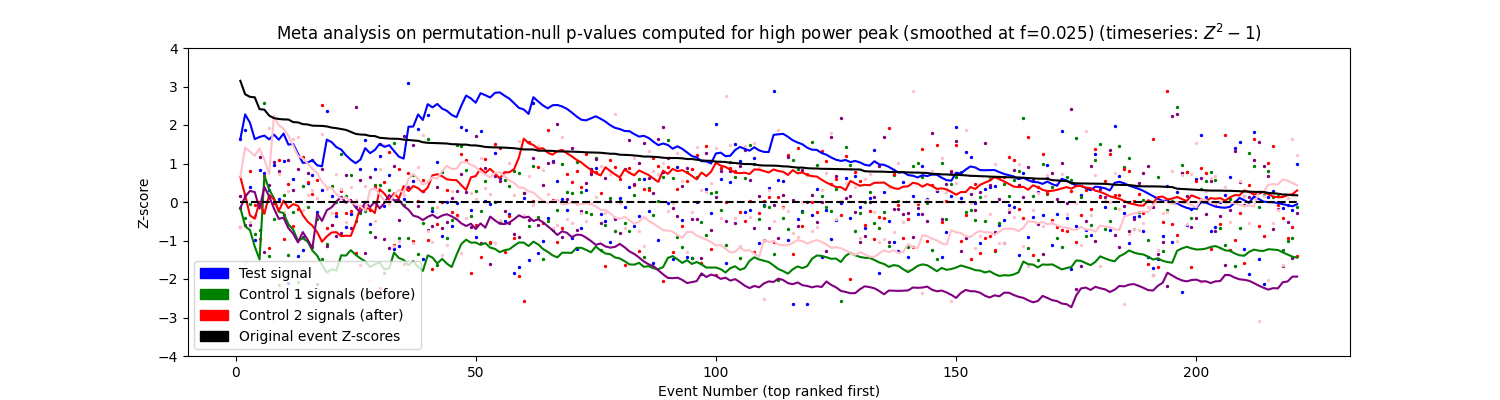

csm1 sumtopnsmooth_p05
Testing for positive meta-analysis z-scores:
test pval: 0.3578
control1 pval: 0.6074
control2 pval: 0.508
control3 pval: 0.5682
control4 pval: 0.2622
Testing for negative meta-analysis z-scores:
test pval: 0.6422
control1 pval: 0.3926
control2 pval: 0.492
control3 pval: 0.4318
control4 pval: 0.7378


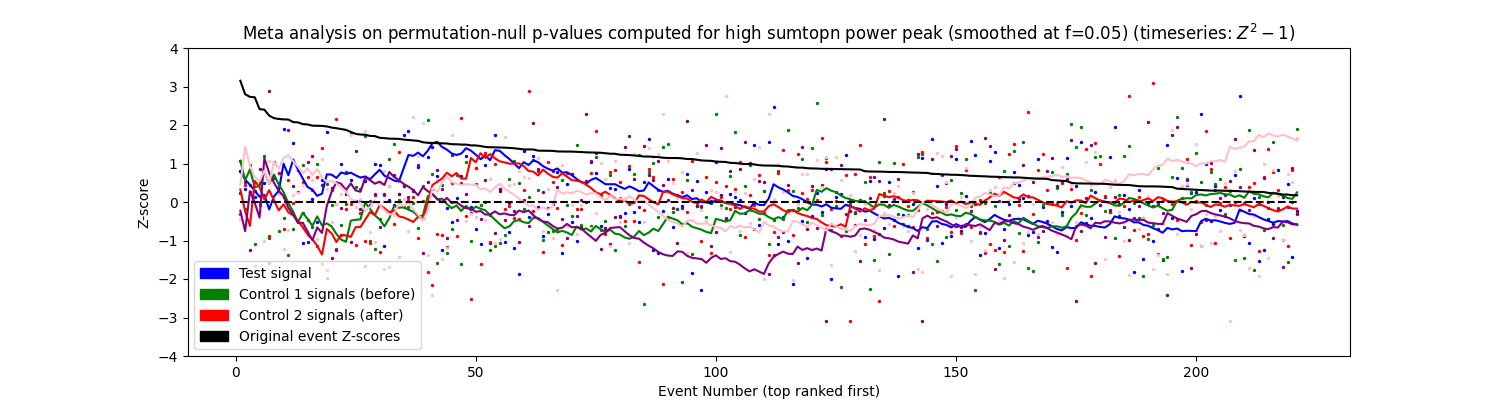

csm1 smooth_p05
Testing for positive meta-analysis z-scores:
test pval: 0.0958
control1 pval: 0.5096
control2 pval: 0.516
control3 pval: 0.5162
control4 pval: 0.519
Testing for negative meta-analysis z-scores:
test pval: 0.9042
control1 pval: 0.4904
control2 pval: 0.484
control3 pval: 0.4838
control4 pval: 0.481


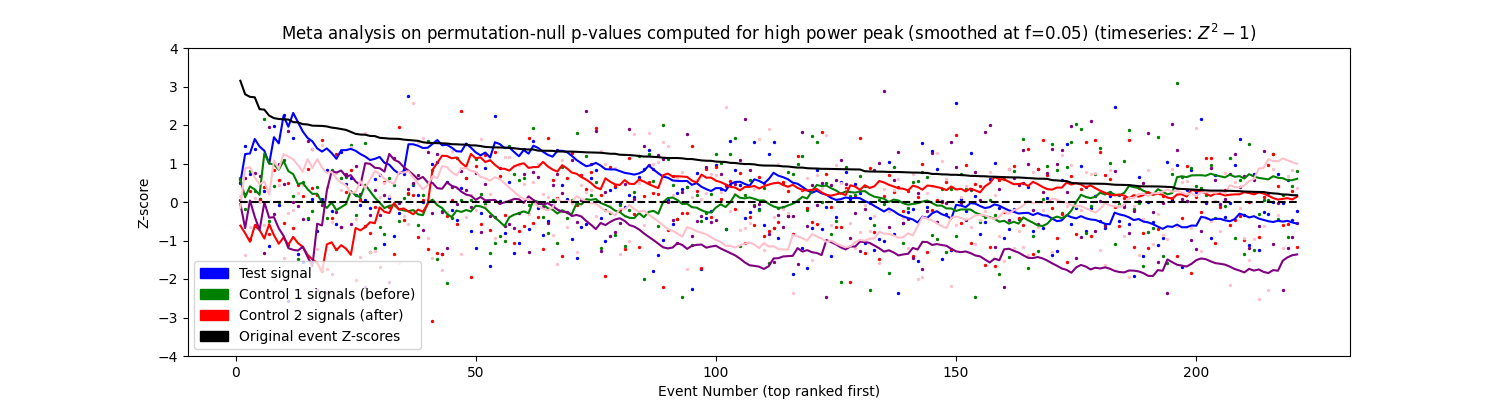

In [13]:
for signalname, signaldisplayname, pvals in [('csm1', '$Z^2 - 1$', pvals_csm1)]:
  print(signalname)
  for metricname, metricdisplayname in [('ljundbox', 'ljundbox'),
                                        ('ef', 'power-weighted frequency'),
                                        ('maxd', 'Max Deviation From Uniform'),
                                        ('sumtopnsmooth_p00625', 'sumtopn power peak (smoothed at f=0.00625)'),
                                        ('smooth_p00625', 'power peak (smoothed at f=0.00625)'),
                                        ('sumtopnsmooth_p0075', 'sumtopn power peak (smoothed at f=0.0075)'),
                                        ('smooth_p0075', 'power peak (smoothed at f=0.0075)'),
                                        ('sumtopnsmooth_p01', 'sumtopn power peak (smoothed at f=0.01)'),
                                        ('smooth_p01', 'power peak (smoothed at f=0.01)'),
                                        ('sumtopnsmooth_p0125', 'sumtopn power peak (smoothed at f=0.0125)'),
                                        ('smooth_p0125', 'power peak (smoothed at f=0.0125)'),
                                        ('sumtopnsmooth_p015', 'sumtopn power peak (smoothed at f=0.015)'),
                                        ('smooth_p015', 'power peak (smoothed at f=0.015)'),
                                        ('sumtopnsmooth_p02', 'sumtopn power peak (smoothed at f=0.02)'),
                                        ('smooth_p02', 'power peak (smoothed at f=0.02)'),
                                        ('sumtopnsmooth_p025', 'sumtopn power peak (smoothed at f=0.025)'),
                                        ('smooth_p025', 'power peak (smoothed at f=0.025)'),
                                        ('sumtopnsmooth_p05', 'sumtopn power peak (smoothed at f=0.05)'),
                                        ('smooth_p05', 'power peak (smoothed at f=0.05)')

                                        ]:
    print(signalname,metricname)
    make_meta_trend_plot(
      "Meta analysis on permutation-null p-values computed for high "
        +metricdisplayname+" (timeseries: "+signaldisplayname+")",
      test_pvals=np.array([x["pval_"+metricname] for x in pvals["test"]]),
      control1_pvals=np.array([x["pval_"+metricname] for x in pvals["control1"]]),
      control2_pvals=np.array([x["pval_"+metricname] for x in pvals["control2"]]),
      control3_pvals=np.array([x["pval_"+metricname] for x in pvals["control3"]]),
      control4_pvals=np.array([x["pval_"+metricname] for x in pvals["control4"]]),
      savefilename=signalname+"_"+metricname)
    display(Image("analysis/metapval_"+signalname+"_"+metricname+".png"))

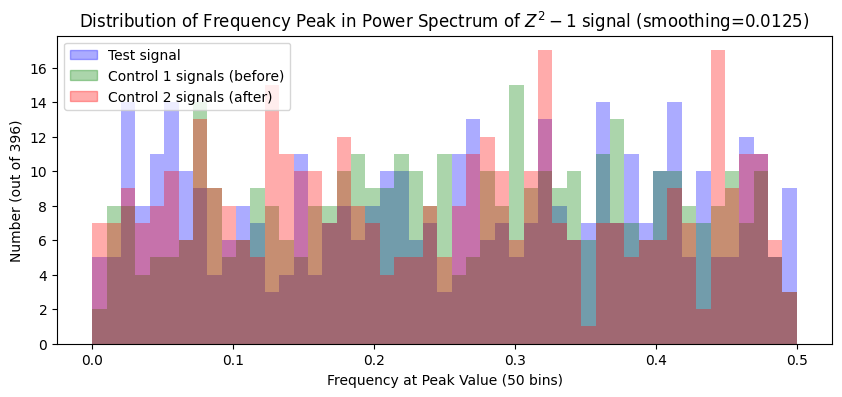

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
_, bins, _ = plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["test"]],
                      bins=np.linspace(0,0.5,50), color="blue", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control1"]],
         bins=np.linspace(0,0.5,50), color="green", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control2"]],
         bins=np.linspace(0,0.5,50), color="red", alpha=0.33)
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal', alpha=0.33),
                    mpatches.Patch(color='green', label='Control 1 signals (before)', alpha=0.33),
                    mpatches.Patch(color='red', label='Control 2 signals (after)', alpha=0.33)],
             loc="upper left")
plt.title("Distribution of Frequency Peak in Power Spectrum of $Z^2 - 1$ signal (smoothing=0.0125)")
plt.xlabel("Frequency at Peak Value (50 bins)")
plt.ylabel("Number (out of "+str(len(pvals_csm1["test"]))+")")
plt.show()